In [1]:
# !pip install tensorflow==2.13.0
# ! pip install numpy pandas tensorflow_addons vit_keras scikit_learn matplotlib seaborn opendatasets opencv-python pydot pyarrow

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras import regularizers
from vit_keras import vit
import tensorflow_addons as tfa
import opendatasets as od
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

2024-03-08 07:32:27.185542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 07:32:27.185635: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 07:32:27.185685: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 07:32:27.196871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.11/dist-packages/tensorflow

In [2]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [ ]:
od.download(
    "https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset")

In [ ]:
! apt update && apt install graphviz -y

In [3]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [4]:
tr_df = train_df('brain-tumor-mri-dataset/Training')
ts_df = test_df('brain-tumor-mri-dataset/Testing')

valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

batch_size = 16
img_size = (224, 224)

_gen = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)


tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

# Build Vision Transformer model
class_dict = tr_gen.class_indices
input_shape = (224, 224, 3)
num_classes = 4

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [5]:
vit_model = vit.vit_b16(
    image_size=224,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
    classes=num_classes
)

model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, 'softmax')
    ],
    name = 'vision_transformer')

2024-03-08 07:32:33.798340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79086 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:00:07.0, compute capability: 8.0


In [6]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 1e-4)
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), metrics=['accuracy',Precision(),Recall()])

In [7]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                               

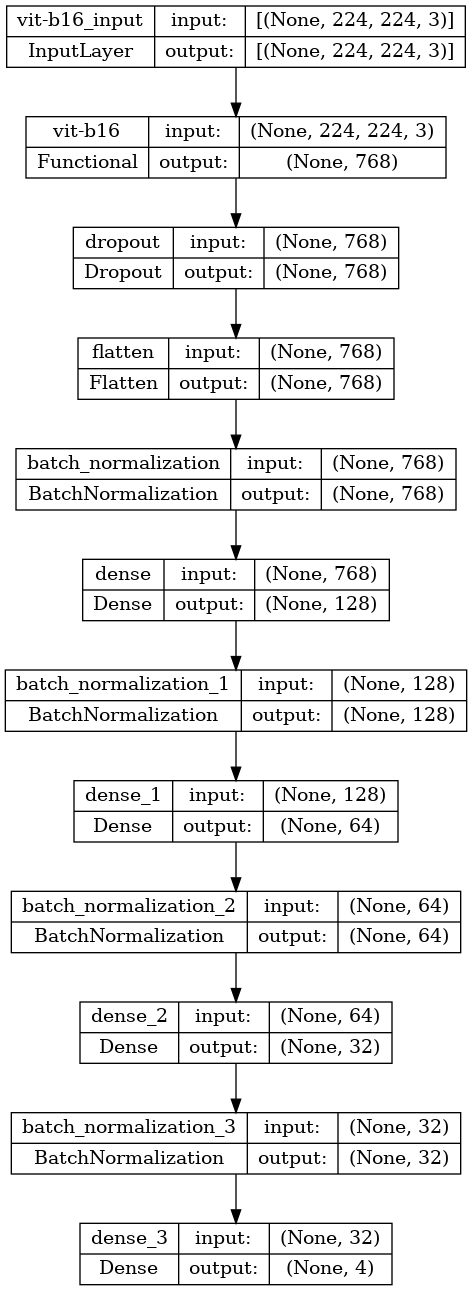

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [9]:
hist = model.fit(tr_gen,  
                 epochs=30,
                 validation_data=valid_gen)

Epoch 1/30


2024-03-08 07:33:00.347528: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-08 07:33:00.353389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-03-08 07:33:00.455211: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


357/357 [==============================] - 97s 208ms/step - loss: 1.2572 - accuracy: 0.6136 - precision: 0.6846 - recall: 0.5270 - val_loss: 1.0489 - val_accuracy: 0.7893 - val_precision: 0.8311 - val_recall: 0.7588
Epoch 2/30
357/357 [==============================] - 72s 201ms/step - loss: 0.8861 - accuracy: 0.8477 - precision: 0.8955 - recall: 0.7981 - val_loss: 0.8363 - val_accuracy: 0.9130 - val_precision: 0.9385 - val_recall: 0.8855
Epoch 3/30
357/357 [==============================] - 72s 201ms/step - loss: 0.7820 - accuracy: 0.9133 - precision: 0.9371 - recall: 0.8734 - val_loss: 0.7714 - val_accuracy: 0.9206 - val_precision: 0.9341 - val_recall: 0.9084
Epoch 4/30
357/357 [==============================] - 72s 201ms/step - loss: 0.7084 - accuracy: 0.9557 - precision: 0.9696 - recall: 0.9266 - val_loss: 0.6804 - val_accuracy: 0.9588 - val_precision: 0.9646 - val_recall: 0.9573
Epoch 5/30
357/357 [==============================] - 72s 201ms/step - loss: 0.6776 - accuracy: 0.9702 

In [10]:
# Save the model
model.save('vit-b16.keras')

In [11]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

In [12]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,1.257245,0.613620,0.684558,0.526961,1.048882,0.789313,0.831104,0.758779
1,0.886079,0.847689,0.895502,0.798144,0.836312,0.912977,0.938511,0.885496
2,0.781962,0.913340,0.937077,0.873424,0.771418,0.920611,0.934066,0.908397
3,0.708425,0.955707,0.969591,0.926646,0.680352,0.958779,0.964615,0.957252
4,0.677618,0.970238,0.977925,0.953957,0.636363,0.980153,0.981595,0.977099
5,0.661568,0.975315,0.982691,0.964111,0.644930,0.970992,0.970992,0.970992
6,0.653577,0.978291,0.982930,0.967787,0.622622,0.984733,0.986196,0.981679
7,0.640858,0.987395,0.990272,0.980217,0.618540,0.989313,0.989264,0.984733
8,0.646478,0.980917,0.983583,0.975490,0.631001,0.978626,0.981595,0.977099
9,0.648426,0.977241,0.980895,0.970763,0.642302,0.966412,0.973643,0.958779


In [13]:
hist_.to_csv('hist_data.csv', index=False)

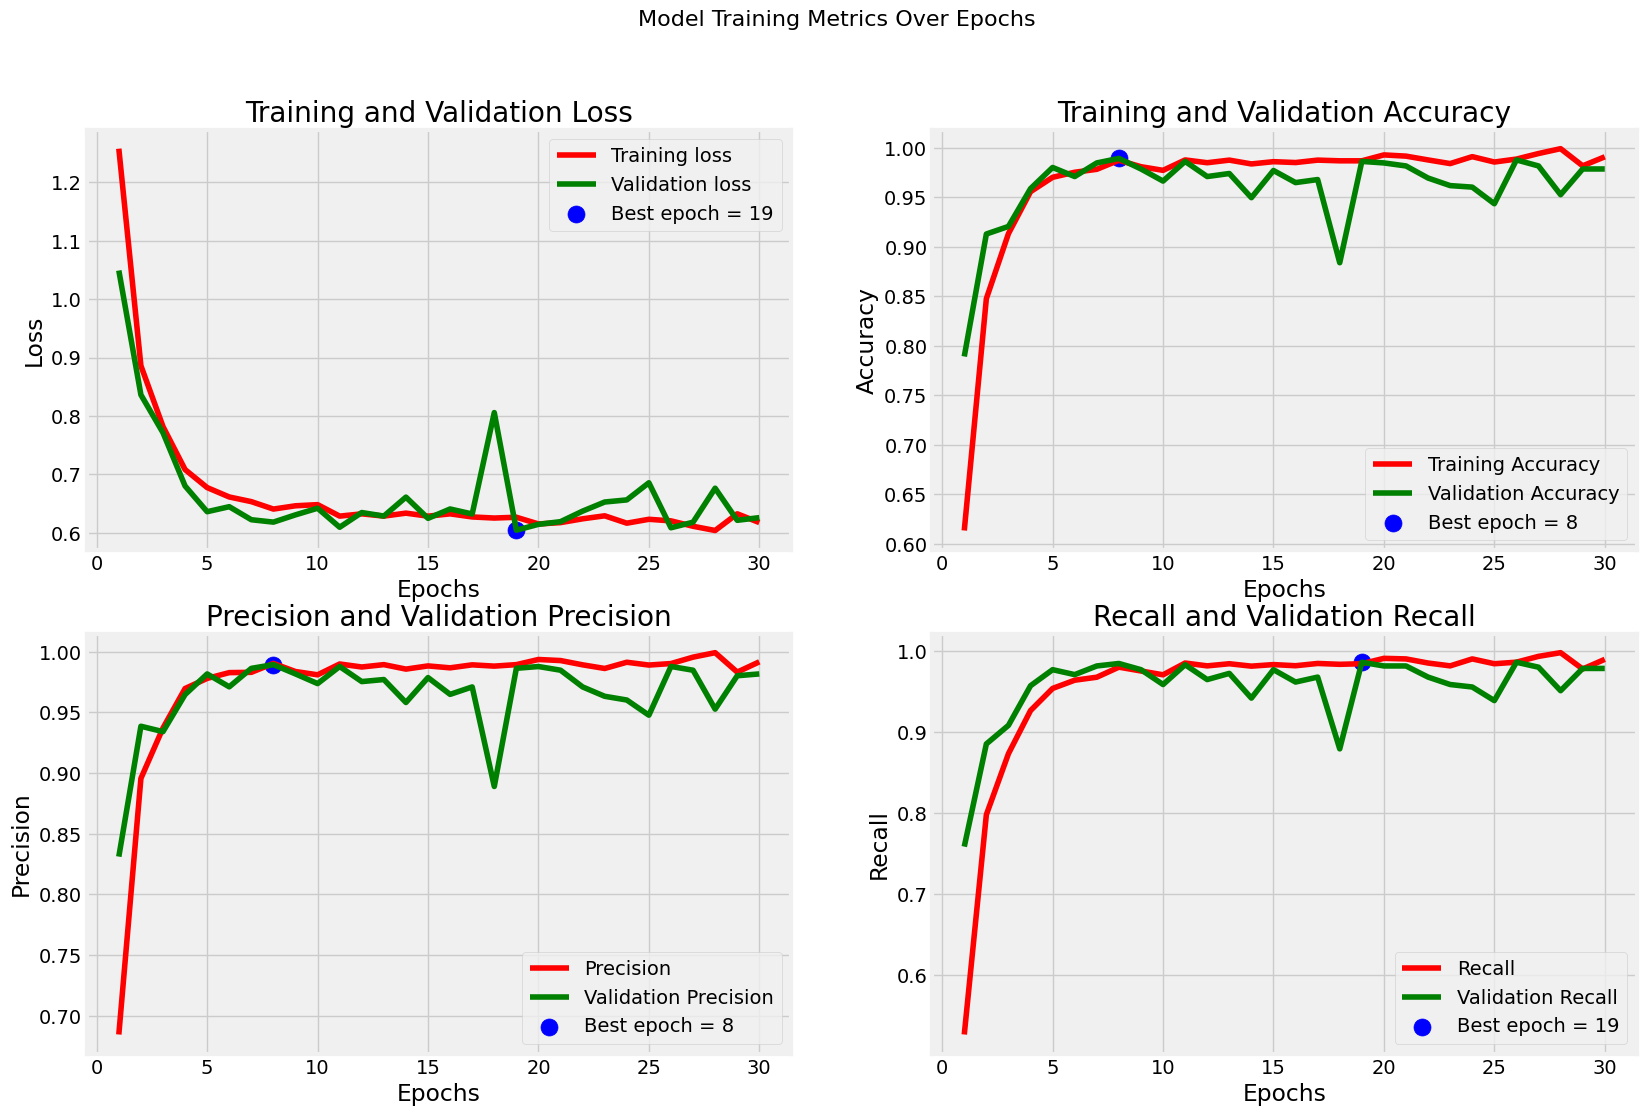

In [14]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']   
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'

plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('TV_Loss.png')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('TV_Acc.png')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig('TV_Loss.png')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [15]:
import numpy as np
import json

data = {
    "tr_acc": tr_acc,
    "tr_loss": tr_loss,
    "tr_per": tr_per,
    "tr_recall": tr_recall,
    "val_acc": val_acc,
    "val_loss": val_loss,
    "val_per": val_per,
    "val_recall": val_recall,
    "index_loss": int(index_loss),
    "val_lowest": float(val_lowest),
    "index_acc": int(index_acc),
    "acc_highest": float(acc_highest),
    "index_precision": int(index_precision),
    "per_highest": float(per_highest),
    "index_recall": int(index_recall),
    "recall_highest": float(recall_highest),
    "Epochs": Epochs,
    "loss_label": loss_label,
    "acc_label": acc_label,
    "per_label": per_label,
    "recall_label": recall_label
}

# Save data to a JSON file
with open('training_metrics.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)

In [16]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")            


41/41 [==============================] - 3s 75ms/step - loss: 0.6247 - accuracy: 0.9802 - precision: 0.9802 - recall: 0.9787
Train Loss: 0.5985
Train Accuracy: 99.40%
--------------------
Validation Loss: 0.6221
Validation Accuracy: 98.32%
--------------------
Test Loss: 0.6247
Test Accuracy: 98.02%


In [17]:
with open('model_scores.txt', 'w') as file:
    file.write("Train Loss: {}\n".format(train_score[0]))
    file.write("Train Accuracy: {}\n".format(train_score[1]))
    file.write('-' * 20 + '\n')
    file.write("Validation Loss: {}\n".format(valid_score[0]))
    file.write("Validation Accuracy: {}\n".format(valid_score[1]))
    file.write('-' * 20 + '\n')
    file.write("Test Loss: {}\n".format(test_score[0]))
    file.write("Test Accuracy: {}\n".format(test_score[1]))

print("Scores saved successfully.")

Scores saved successfully.


In [18]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 [==============================] - 5s 70ms/step


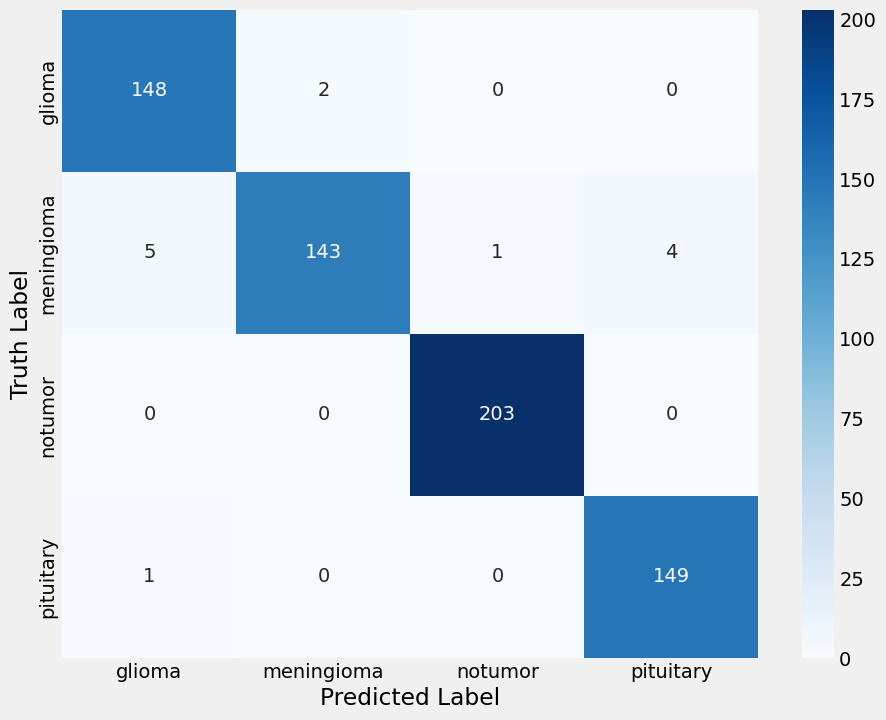

In [19]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.savefig('Confusion_Matrix.png')
plt.show()

In [20]:
import json
classes = list(ts_gen.class_indices.keys())
print(classification_report(ts_gen.classes, y_pred , target_names= classes ))

# Save the classification report to json 
report = classification_report(ts_gen.classes, y_pred , target_names= classes , output_dict= True)
report_df = pd.DataFrame(report).transpose()
report_df.to_json('classification_report.json')

              precision    recall  f1-score   support

      glioma       0.96      0.99      0.97       150
  meningioma       0.99      0.93      0.96       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.97      0.99      0.98       150

    accuracy                           0.98       656
   macro avg       0.98      0.98      0.98       656
weighted avg       0.98      0.98      0.98       656



In [21]:
precision = report_df['precision']
recall = report_df['recall']
f1_score = report_df['f1-score']
classes = report_df.index

# Calculate TPR and FPR for each class
tpr = recall
fpr = 1 - precision

# Save TPR and FPR to a DataFrame
tpr_fpr_df = pd.DataFrame({'TPR': tpr, 'FPR': fpr}, index=classes)


tpr_fpr_json = tpr_fpr_df.to_json(orient='index')
print(tpr_fpr_df)
# Write JSON to file
with open('tpr_fpr.json', 'w') as f:
    json.dump(tpr_fpr_json, f)

print("TPR and FPR saved as JSON.")

                   TPR       FPR
glioma        0.986667  0.038961
meningioma    0.934641  0.013793
notumor       1.000000  0.004902
pituitary     0.993333  0.026144
accuracy      0.980183  0.019817
macro avg     0.978660  0.020950
weighted avg  0.980183  0.019621
TPR and FPR saved as JSON.


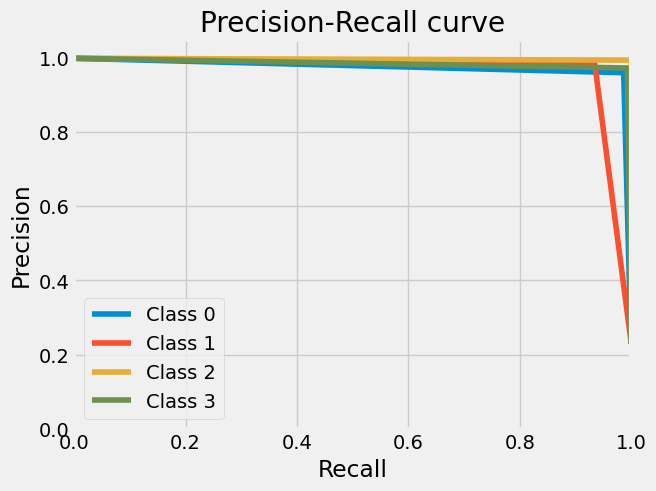

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Assuming you have predictions (preds) and true labels (y_true) for your test set
num_classes = 4
# Get true labels from test_gen
y_true = np.array(ts_gen.classes)

# Binarize the predicted probabilities or scores
y_pred_binarized = label_binarize(y_pred, classes=range(num_classes))

# Calculate precision and recall for each class separately
precision = dict()
recall = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve((y_true == i).astype(int), y_pred_binarized[:, i])
    plt.plot(recall[i], precision[i], label='Class {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.savefig('precision_recall_curve_multiclass.png')
plt.show()


In [23]:
def predict(img_path):
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image
    label = list(class_dict.keys())
    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = model.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [24]:
import sys

# Save model summary to a text file
with open('model_summary.txt', 'w') as f:
    # Redirect stdout to the text file
    sys.stdout = f
    # Print the model summary
    model.summary()
    # Reset stdout to the console
    sys.stdout = sys.__stdout__

print("Model summary saved as 'model_summary.txt'")

Model summary saved as 'model_summary.txt'
